In [9]:
# Step 1: Import necessary libraries
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Step 2: Load the .mat file
mat_file_path = "dataset/BRCA1View1000.mat"
mat_data = scipy.io.loadmat(mat_file_path)


In [3]:
# Step 3: Inspect the keys in the .mat file
print("Keys in the MAT file:", mat_data.keys())

Keys in the MAT file: dict_keys(['__header__', '__version__', '__globals__', 'data', 'targets'])


In [4]:
# Step 4: Extract the gene expression matrix and target labels
X = mat_data['data']          # shape: genes x samples
y = mat_data['targets'].flatten()  # shape: samples



In [5]:
print("\nShape of gene expression matrix (genes x samples):", X.shape)
print("Shape of target vector (samples):", y.shape)
print("Unique classes:", np.unique(y))


Shape of gene expression matrix (genes x samples): (1000, 2133)
Shape of target vector (samples): (2133,)
Unique classes: [1 2 3 4 5 6]


In [6]:
# Step 5: Optional - basic statistics
print("\nGene expression statistics:")
print("Min:", X.min(), "Max:", X.max())
print("Mean:", X.mean(), "Std:", X.std())


Gene expression statistics:
Min: 0.0 Max: 1.0
Mean: 0.3314029448560866 Std: 0.1931370862564709


In [7]:
# Step 6: Convert to DataFrame for easier handling (samples x genes)
gene_df = pd.DataFrame(X.T)  # transpose so rows = samples, columns = genes
gene_df['Subtype'] = y       # add target labels as a new column

print("\nFirst 5 rows of the dataset:")
print(gene_df.head())


First 5 rows of the dataset:
          0         1         2         3         4         5         6  \
0  0.276338  0.243315  0.098696  0.948949  0.424548  0.728649  0.576157   
1  0.998155  0.491584  0.682874  0.518834  0.128112  0.036587  0.828786   
2  0.464005  0.127223  0.150458  0.313084  0.198929  0.101602  0.889156   
3  0.708256  0.990991  0.227884  0.413478  0.248705  0.674076  0.559691   
4  0.912457  1.000000  0.802602  0.581899  0.369224  0.057715  0.546891   

          7         8         9  ...       991       992       993       994  \
0  0.373383  0.131070  0.302040  ...  0.380823  0.868204  0.151193  0.286462   
1  0.161189  0.131813  0.186915  ...  0.325502  1.000000  0.118998  0.526340   
2  0.553299  0.622338  0.802808  ...  0.441346  0.905243  0.087547  0.354501   
3  0.484117  0.206005  0.554822  ...  0.478284  0.967476  0.115522  0.339239   
4  0.734533  0.104131  0.394168  ...  0.421073  0.797633  0.128767  0.220795   

        995       996       997       

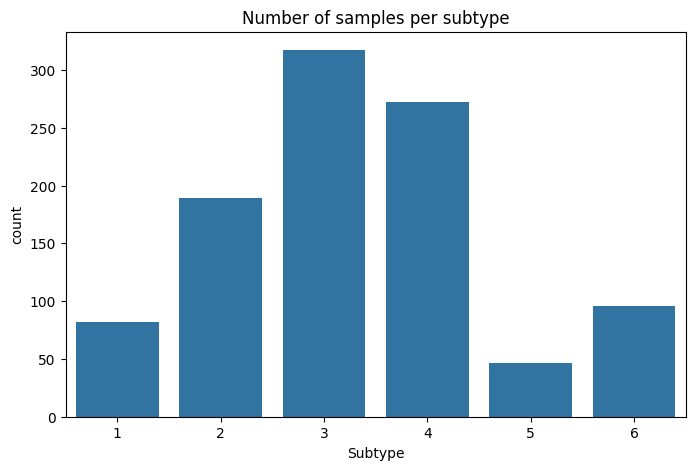

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x='Subtype', data=gene_df)
plt.title("Number of samples per subtype")
plt.show()

In [17]:
# Count number of samples in each subtype
class_counts = gene_df['Subtype'].value_counts()
print("Number of samples per subtype:")
print(class_counts)

Number of samples per subtype:
Subtype
4    776
3    630
1    266
2    251
6    144
5     66
Name: count, dtype: int64


In [11]:
gene_stats = gene_df.drop(columns='Subtype').describe().T
print(gene_stats.head())  # mean, std, min, max for first few genes


    count      mean       std       min       25%       50%       75%  max
0  2133.0  0.614005  0.311630  0.000000  0.339460  0.679522  0.910286  1.0
1  2133.0  0.470317  0.308354  0.022711  0.189185  0.395468  0.750537  1.0
2  2133.0  0.425992  0.298759  0.000000  0.145726  0.373967  0.679212  1.0
3  2133.0  0.589873  0.298137  0.015603  0.337417  0.638789  0.855400  1.0
4  2133.0  0.431111  0.278175  0.020986  0.160396  0.425025  0.659510  1.0


In [12]:
missing = gene_df.isnull().sum().sum()
print("Total missing values in dataset:", missing)


Total missing values in dataset: 0


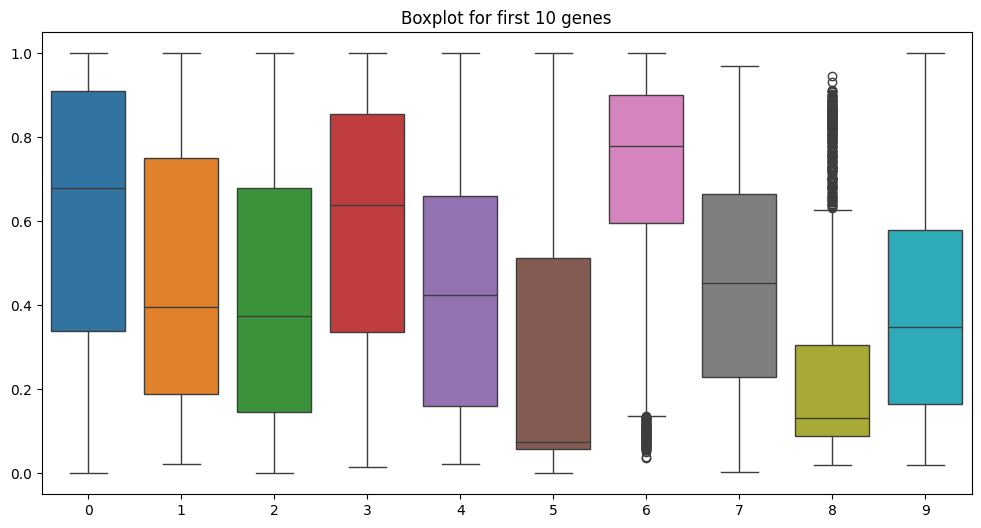

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=gene_df.iloc[:, :10])  # first 10 genes
plt.title("Boxplot for first 10 genes")
plt.show()


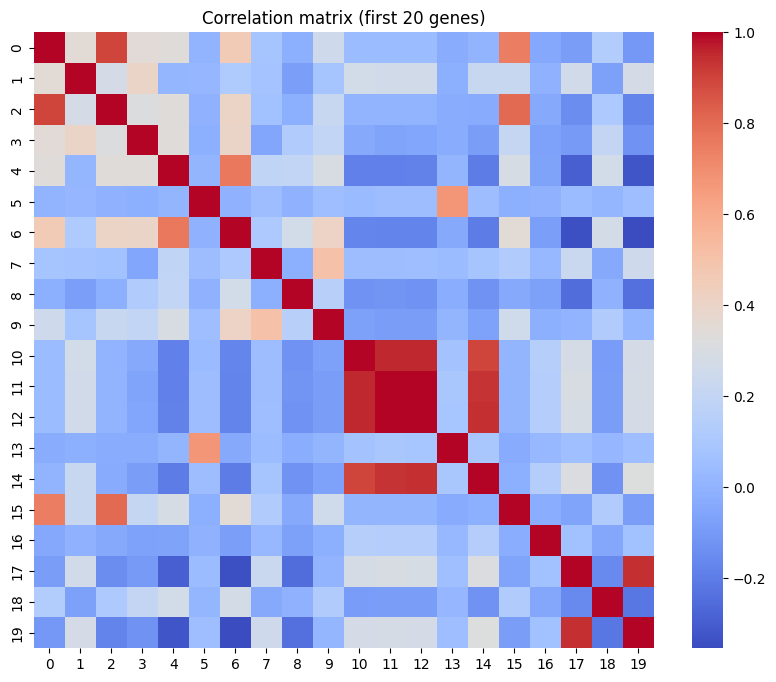

In [14]:
# Compute correlation for first 20 genes to keep it readable
corr_matrix = gene_df.iloc[:, :20].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation matrix (first 20 genes)")
plt.show()
